# Changeover

calculated using BATCHACTIVE and CNTR_GOOD files

In BATCHACTIVE: -1 is active, 0 is inactive

So, if it was -1 and is now 0, we've just started a changeover

In CNTR_GOOD: 0 is stopped, and as soon as it increases changeover has finished

In [1]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is /Users/mark/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD
dir_local is /Users/mark/Documents/McLaren2021/Sanofi/


In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
# read IP21 SPEED files for AL6 packaging machines
folder = 'IP21_data'

Files = []
df_BATCHACTIVE = pd.DataFrame()
df_CNTR_GOOD = pd.DataFrame()
path = os.path.join(dir_sanofi_share, folder)

for filename in os.listdir( path ):
    # this will only find files for Assembly and Packaging
    if '36680902_BATCHACTIVE' in filename:
        path = os.path.join(dir_sanofi_share, folder, filename)
        df_BATCHACTIVE = pd.read_csv(path)

    if '36680902_CNTR_GOOD' in filename:
        path = os.path.join(dir_sanofi_share, folder, filename)
        df_CNTR_GOOD = pd.read_csv(path)
        



In [48]:
df_CNTR_GOOD = df_CNTR_GOOD.sort_values('IP_TREND_TIME')
df_BATCHACTIVE = df_BATCHACTIVE.sort_values('IP_TREND_TIME')
df_changeover = []
# find where previous row was -1 (active) and this row is 0 (inactive) - this is the start of changeover
df_changeover = df_BATCHACTIVE[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_BATCHACTIVE['IP_TREND_VALUE'].shift(1) == -1) & (df_BATCHACTIVE['IP_TREND_VALUE'] == 0)]

# find where previous row was 0 (batch not started) and this row is >1 (batch running) - changeover has finished
df_changeover = df_changeover.append(df_CNTR_GOOD[['Name','IP_TREND_TIME','IP_TREND_VALUE']][(df_CNTR_GOOD['IP_TREND_VALUE'].shift(1) == 0) & (df_CNTR_GOOD['IP_TREND_VALUE'] > 0)])
df_changeover.sort_values('IP_TREND_TIME', inplace=True)
df_changeover

,Name,IP_TREND_TIME,IP_TREND_VALUE
2455,36680902_BATCHACTIVE,02-AUG-21 22:47:04.1,0
22888,36680902_CNTR_GOOD,02-AUG-21 23:33:13.2,1
2328,36680902_BATCHACTIVE,03-AUG-21 19:48:39.6,0
20903,36680902_CNTR_GOOD,03-AUG-21 21:08:45.1,1
2296,36680902_BATCHACTIVE,04-AUG-21 00:56:14.2,0
20587,36680902_CNTR_GOOD,04-AUG-21 02:05:46.1,1
2258,36680902_BATCHACTIVE,04-AUG-21 07:01:24.9,0
20195,36680902_CNTR_GOOD,04-AUG-21 07:37:14.5,1
2034,36680902_BATCHACTIVE,05-AUG-21 20:07:04.2,0
16637,36680902_CNTR_GOOD,05-AUG-21 20:50:02.0,1


In [49]:
# convert dates to datetime format
df_changeover['IP_TREND_TIME'] = pd.to_datetime(df_changeover['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')

In [50]:
# find the speed and time diff
df_changeover['time_diff_mins'] = df_changeover.IP_TREND_TIME.diff().dt.seconds / 60
df_changeover['time_diff_mins'].fillna(0, inplace=True)
df_changeover['time_diff_mins'] = np.array(df_changeover['time_diff_mins'], dtype=np.int)
df_changeover.set_index('IP_TREND_TIME', inplace=True)

df_changeover

,Name,IP_TREND_VALUE,time_diff_mins
IP_TREND_TIME,,,
2021-08-02 22:47:04.100,36680902_BATCHACTIVE,0,0
2021-08-02 23:33:13.200,36680902_CNTR_GOOD,1,46
2021-08-03 19:48:39.600,36680902_BATCHACTIVE,0,1215
2021-08-03 21:08:45.100,36680902_CNTR_GOOD,1,80
2021-08-04 00:56:14.200,36680902_BATCHACTIVE,0,227
2021-08-04 02:05:46.100,36680902_CNTR_GOOD,1,69
2021-08-04 07:01:24.900,36680902_BATCHACTIVE,0,295
2021-08-04 07:37:14.500,36680902_CNTR_GOOD,1,35
2021-08-05 20:07:04.200,36680902_BATCHACTIVE,0,749


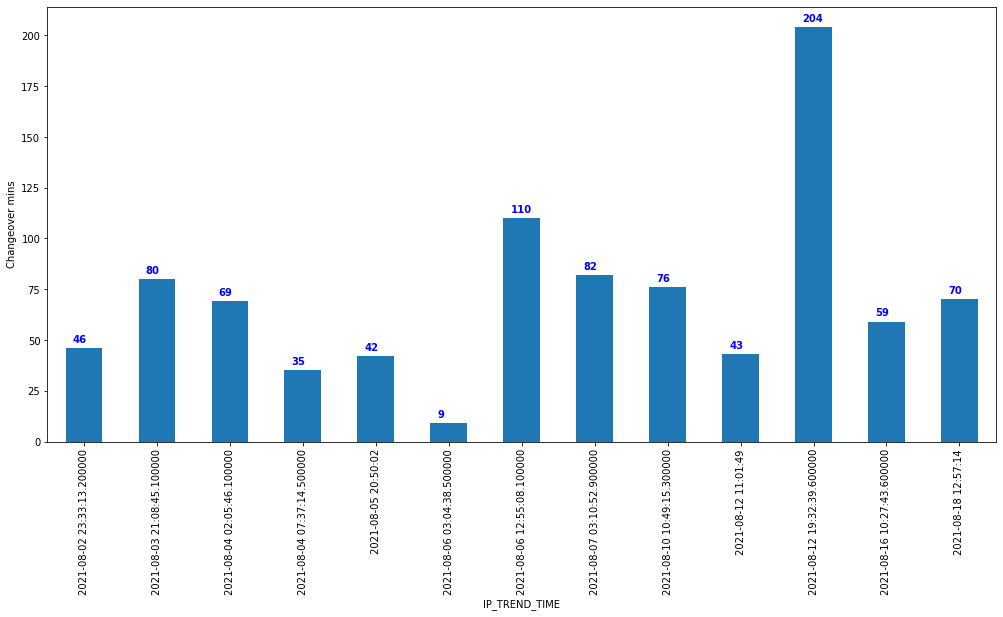

In [55]:
# group_unstacked = df_changeover.groupby([pd.Grouper(freq='D'), 'IP_TREND_VALUE'])['time_diff_secs'].sum().unstack(level=1)
# group_unstacked.set_index('IP_TREND_TIME', inplace=True)
# group_unstacked.plot.area(figsize=(17,10))

fig, ax = plt.subplots(1, 1, figsize=(17, 8))

df_changeover[df_changeover.IP_TREND_VALUE == 1]['time_diff_mins'].plot.bar(ax=ax)
ax.set_ylabel('Changeover mins')

for i, v in enumerate(df_changeover[df_changeover.IP_TREND_VALUE == 1]['time_diff_mins']):
    ax.text(i - .15, v + 3, str(v), color='blue', fontweight='bold')



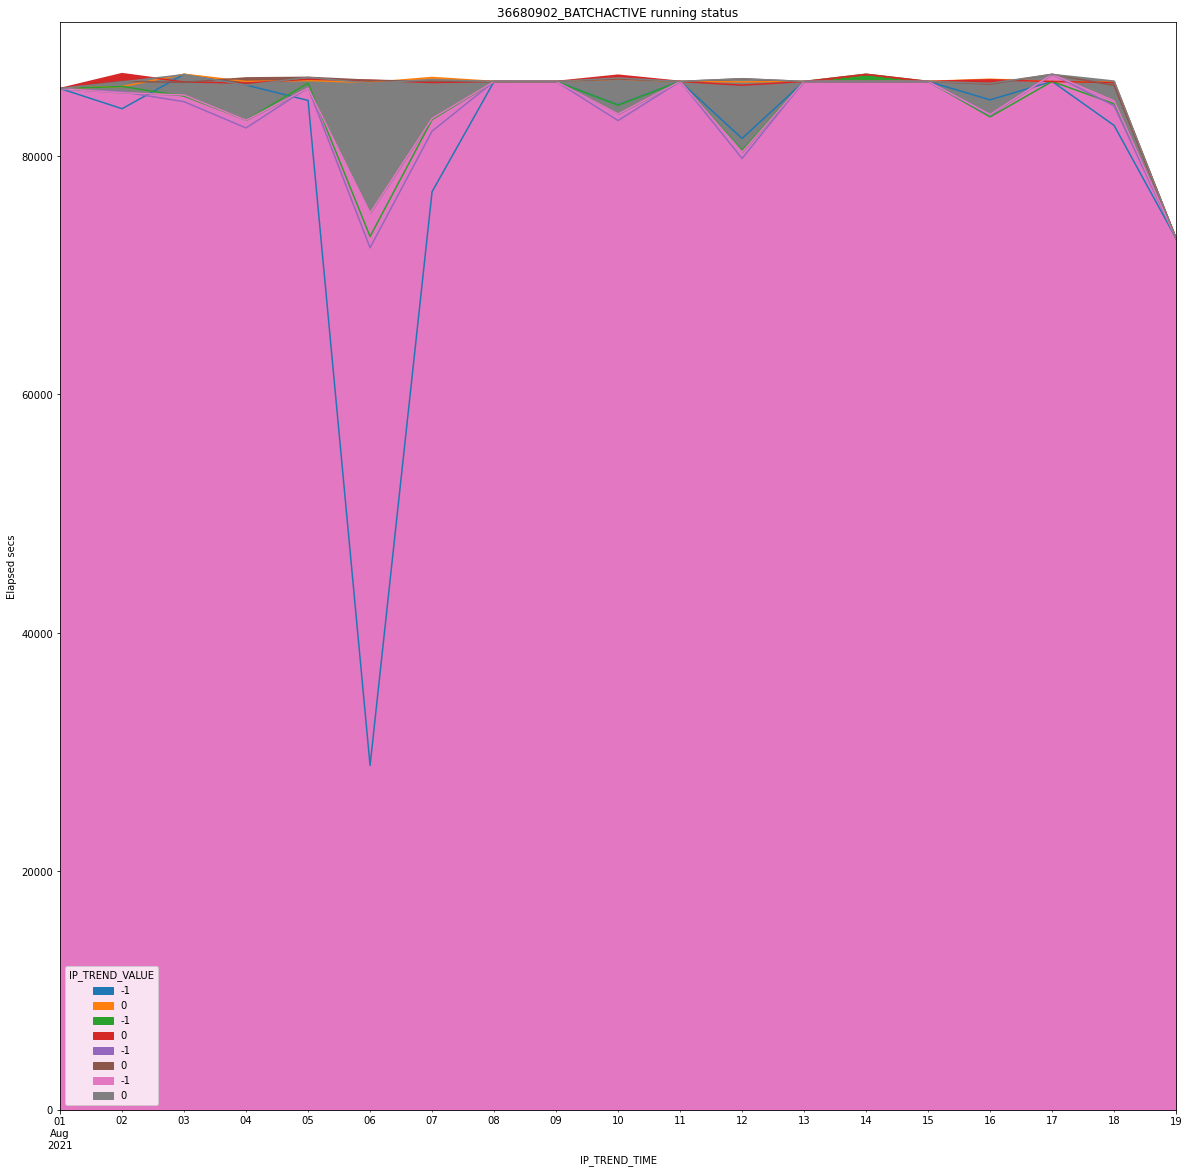

In [90]:
freq='1min'

fig, axs = plt.subplots(1, 1, figsize=(20, 20))

for x in group_unstacked.Name.unique():
    group_unstacked[group_unstacked.Name == x].plot.area(ax=axs)
    axs.set_title('{} running status'.format(x))
    axs.set_ylabel('Elapsed secs')

In [8]:
df_changeover[df_changeover.IP_TREND_VALUE == 1]['time_diff_mins']

IP_TREND_TIME
2021-08-02 23:33:13.200     46.0
2021-08-03 21:08:45.100     80.0
2021-08-04 02:05:46.100     70.0
2021-08-04 07:37:14.500     36.0
2021-08-05 20:50:02.000     43.0
2021-08-06 03:04:38.500     10.0
2021-08-06 12:55:08.100    110.0
2021-08-07 03:10:52.900     82.0
2021-08-10 10:49:15.300     76.0
2021-08-12 11:01:49.000     44.0
2021-08-12 19:32:39.600    205.0
2021-08-16 10:27:43.600     60.0
2021-08-18 12:57:14.000     71.0
Name: time_diff_mins, dtype: float64